<a href="https://colab.research.google.com/github/suryanshshah2006/Brain-Tumor-detection/blob/main/Brain_Tumor_Classification_using_ShallowMri_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle

In [2]:
import json
import os

kaggle_username = 'suryanshshah'
kaggle_token = 'KGAT_c6e62e674ce15cae2dd30a93bf313757'

! mkdir -p ~/.kaggle
with open('kaggle.json', 'w') as f:
    json.dump({"username": kaggle_username, "key": kaggle_token}, f)

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

print("Kaggle authentication successful!")

Kaggle authentication successful!


In [3]:
! kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
  0% 0.00/149M [00:00<?, ?B/s]
100% 149M/149M [00:00<00:00, 2.08GB/s]


In [4]:
! unzip brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from skimage import feature
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

print("TensorFlow version:", tf.__version__)
print("OpenCV version:", cv2.__version__)

TensorFlow version: 2.19.0
OpenCV version: 4.12.0


In [6]:
img_size = (224, 224)
batch_size = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/Training',
    validation_split=0.123,
    subset="training",
    seed=123,
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',
    shuffle = True
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/Training',
    validation_split=0.123,
    subset="validation",
    seed=123,
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/Testing',
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False,
    color_mode='grayscale'
)

Found 5712 files belonging to 4 classes.
Using 5010 files for training.
Found 5712 files belonging to 4 classes.
Using 702 files for validation.
Found 1311 files belonging to 4 classes.


In [7]:
for images, labels in train_ds.take(1):
    print(f"Batch Image Shape: {images.shape}")
    print(f"Batch Label Shape: {labels.shape}")

    print(f"Min pixel value: {np.min(images[0])}")
    print(f"Max pixel value: {np.max(images[0])}")

Batch Image Shape: (16, 224, 224, 1)
Batch Label Shape: (16, 4)
Min pixel value: 0.0
Max pixel value: 255.0


In [8]:
def gaussian_kernel(ksize=5, sigma=1.0, channels=1):
    ax = tf.range(-(ksize // 2), (ksize // 2) + 1, dtype=tf.float32)
    xx, yy = tf.meshgrid(ax, ax)
    kernel = tf.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    kernel = kernel / tf.reduce_sum(kernel)

    kernel = kernel[:, :, tf.newaxis, tf.newaxis]
    kernel = tf.repeat(kernel, repeats=channels, axis=2)
    return kernel

In [9]:
def gaussian_blur_tf(images, labels, ksize=5, sigma=1.0):
    images = tf.cast(images, tf.float32)

    images = tf.cond(
        tf.reduce_max(images) > 1.5,
        lambda: images / 255.0,
        lambda: images
    )

    kernel = gaussian_kernel(ksize=ksize, sigma=sigma, channels=1)

    blurred = tf.nn.depthwise_conv2d(
         images, kernel,
        strides=[1, 1, 1, 1],
        padding="SAME"
    )
    return blurred, labels

In [10]:
train_ds_blur = train_ds.map(lambda x, y: gaussian_blur_tf(x, y, ksize=5, sigma=1.0))
validation_ds_blur = validation_ds.map(lambda x, y: gaussian_blur_tf(x, y, ksize=5, sigma=1.0))
test_ds_blur = test_ds.map(lambda x, y: gaussian_blur_tf(x, y, ksize=5, sigma=1.0))

In [11]:
def visualize_before_after(original_ds, blurred_ds):
    x0, y0 = next(iter(original_ds))
    x1, y1 = next(iter(blurred_ds))

    idx = np.random.randint(0, x0.shape[0])

    img_before = x0[idx].numpy().squeeze()
    img_after  = x1[idx].numpy().squeeze()
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_before, cmap="gray")
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img_after, cmap="gray")
    plt.title("Gaussian Blur (TF)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

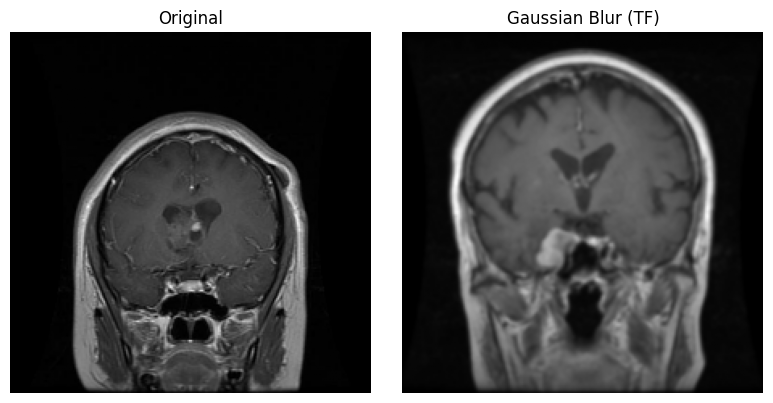

In [12]:
visualize_before_after(train_ds, train_ds_blur)

In [13]:
def threshold_paper_tf(images, labels, thr=45.0):
    thr01 = thr / 255.0
    binary01 = tf.where(images > thr01, 1.0, 0.0)

    return binary01, labels

In [14]:
train_ds_blur_thr = train_ds_blur.map(lambda x, y: threshold_paper_tf(x, y, thr=45.0))
validation_ds_blur_thr = validation_ds_blur.map(lambda x, y: threshold_paper_tf(x, y, thr=45.0))
test_ds_blur_thr = test_ds_blur.map(lambda x, y: threshold_paper_tf(x, y, thr=45.0))


In [15]:
def visualize_blur_vs_threshold(blurred_ds, thresholded_ds):
    xb, yb = next(iter(blurred_ds))
    xt, yt = next(iter(thresholded_ds))

    idx = np.random.randint(0, xb.shape[0])

    plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    plt.imshow(xb[idx].numpy().squeeze(), cmap="gray")
    plt.title("Gaussian Blur")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(xt[idx].numpy().squeeze(), cmap="gray")
    plt.title("Binary Threshold (T=45)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


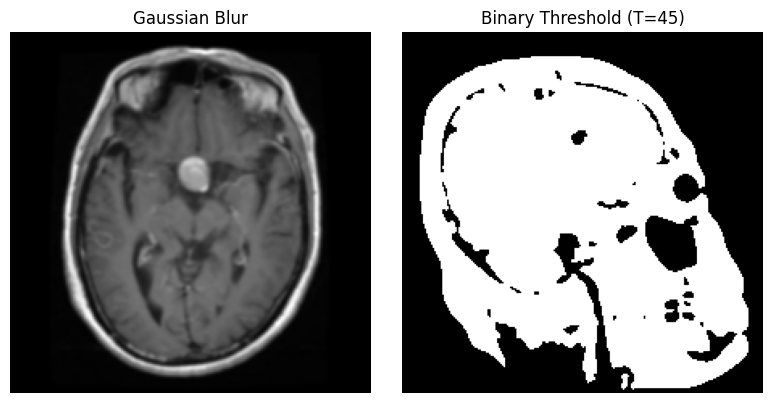

In [16]:
visualize_blur_vs_threshold(train_ds_blur, train_ds_blur_thr)


In [17]:
import tensorflow as tf

def morph_paper_tf(images, labels, ksize=3, erode_iters=2, dilate_iters=1):
    x = tf.cast(images, tf.float32)

    kernel = tf.zeros((ksize, ksize, 1), dtype=tf.float32)

    for _ in range(erode_iters):
        x = tf.nn.erosion2d(
            x, kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
            data_format="NHWC",
            dilations=[1, 1, 1, 1]
        )

    for _ in range(dilate_iters):
        x = tf.nn.dilation2d(
            x, kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
            data_format="NHWC",
            dilations=[1, 1, 1, 1]
        )

    x = tf.where(x > 0.5, 1.0, 0.0)
    return x, labels


In [18]:
train_ds_blur_thr_morph = train_ds_blur_thr.map(
    lambda x, y: morph_paper_tf(x, y, ksize=3, erode_iters=2, dilate_iters=1)
)

validation_ds_blur_thr_morph = validation_ds_blur_thr.map(
    lambda x, y: morph_paper_tf(x, y, ksize=3, erode_iters=2, dilate_iters=1)
)

test_ds_blur_thr_morph = test_ds_blur_thr.map(
    lambda x, y: morph_paper_tf(x, y, ksize=3, erode_iters=2, dilate_iters=1)
)


In [19]:
def visualize_threshold_vs_morph(threshold_ds, morph_ds):
    xt, _ = next(iter(threshold_ds))
    xm, _ = next(iter(morph_ds))

    idx = np.random.randint(0, xt.shape[0])

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(xt[idx].numpy().squeeze(), cmap="gray")
    plt.title("After Threshold (T=45)")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(xm[idx].numpy().squeeze(), cmap="gray")
    plt.title("After Morphology (Erode×2 → Dilate×1)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


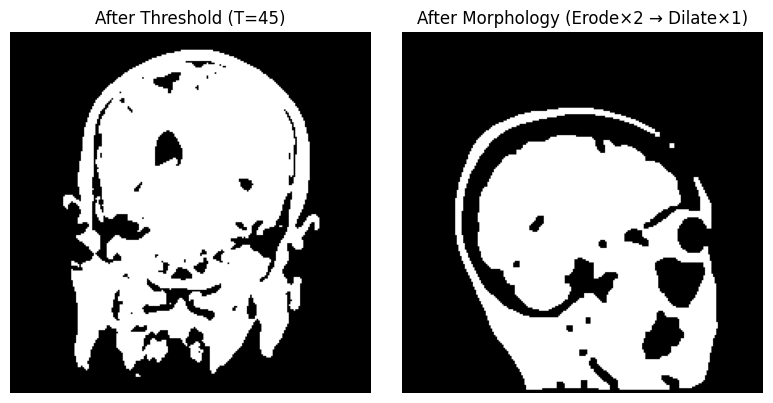

In [20]:
visualize_threshold_vs_morph(train_ds_blur_thr, train_ds_blur_thr_morph)

In [21]:
def crop_by_mask_tf(blur_images, mask_images, labels, out_size=(224,224), pad=6):
    blur_images = tf.cast(blur_images, tf.float32)
    mask = tf.cast(mask_images > 0.5, tf.float32)

    H = tf.shape(mask)[1]
    W = tf.shape(mask)[2]
    pad = tf.cast(pad, tf.int32)

    def _crop_one(args):
        img, msk, lab = args
        m = tf.squeeze(msk, axis=-1)

        coords = tf.where(m > 0.0)
        coords = tf.cast(coords, tf.int32)

        def no_fg():
            resized = tf.image.resize(img, out_size, method="bilinear")
            return resized, lab

        def has_fg():
            y_min = tf.reduce_min(coords[:, 0])
            y_max = tf.reduce_max(coords[:, 0])
            x_min = tf.reduce_min(coords[:, 1])
            x_max = tf.reduce_max(coords[:, 1])

            y_min_p = tf.maximum(y_min - pad, 0)
            x_min_p = tf.maximum(x_min - pad, 0)
            y_max_p = tf.minimum(y_max + pad, H - 1)
            x_max_p = tf.minimum(x_max + pad, W - 1)

            crop = img[y_min_p:y_max_p+1, x_min_p:x_max_p+1, :]
            resized = tf.image.resize(crop, out_size, method="bilinear")
            return resized, lab

        out_img, out_lab = tf.cond(tf.shape(coords)[0] > 0, has_fg, no_fg)
        return out_img, out_lab

    cropped_imgs, out_labels = tf.map_fn(
        _crop_one,
        (blur_images, mask, labels),
        fn_output_signature=(tf.float32, labels.dtype)
    )

    return cropped_imgs, out_labels


In [22]:
paired_train = tf.data.Dataset.zip((train_ds_blur, train_ds_blur_thr_morph))
paired_val   = tf.data.Dataset.zip((validation_ds_blur, validation_ds_blur_thr_morph))
paired_test  = tf.data.Dataset.zip((test_ds_blur, test_ds_blur_thr_morph))


In [23]:
train_ds_roi = paired_train.map(
    lambda a, b: crop_by_mask_tf(a[0], b[0], a[1], out_size=(224,224), pad=6)
)

validation_ds_roi = paired_val.map(
    lambda a, b: crop_by_mask_tf(a[0], b[0], a[1], out_size=(224,224), pad=6)
)

test_ds_roi = paired_test.map(
    lambda a, b: crop_by_mask_tf(a[0], b[0], a[1], out_size=(224,224), pad=6)
)


In [24]:
def visualize_roi_from_pair(paired_ds, roi_ds, n=1):
    (blur_batch, y1), (mask_batch, y2) = next(iter(paired_ds))
    roi_batch, y3 = next(iter(roi_ds))

    bsz = blur_batch.shape[0]
    for _ in range(n):
        idx = np.random.randint(0, bsz)

        blur_img = blur_batch[idx].numpy().squeeze()
        mask_img = mask_batch[idx].numpy().squeeze()
        roi_img  = roi_batch[idx].numpy().squeeze()

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(blur_img, cmap="gray")
        plt.title("Blurred image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(mask_img, cmap="gray")
        plt.title("Mask (after morph)")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(roi_img, cmap="gray")
        plt.title("Cropped ROI (resized 224×224)")
        plt.axis("off")

        plt.tight_layout()
        plt.show()


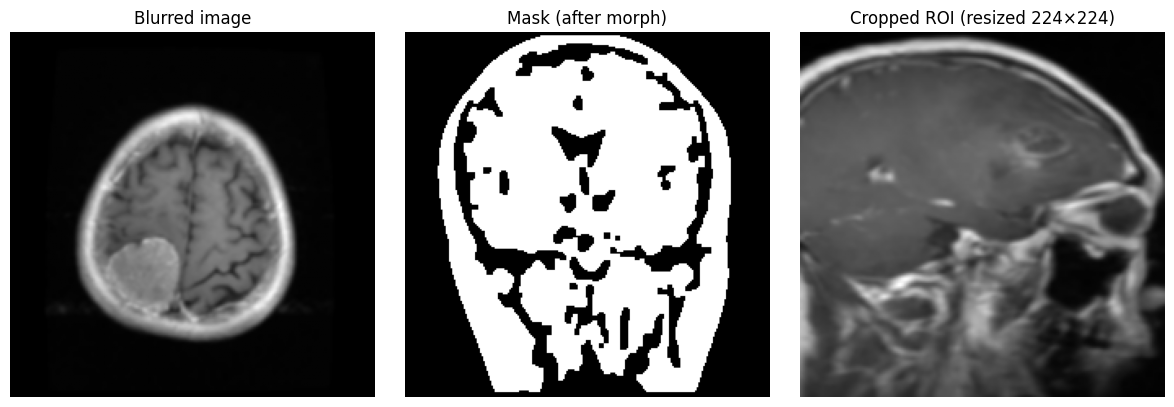

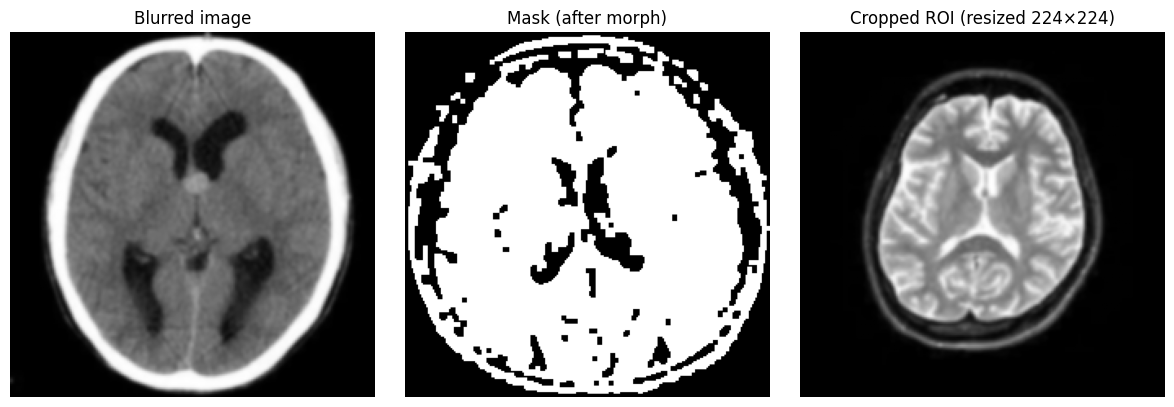

In [25]:
visualize_roi_from_pair(paired_train, train_ds_roi, n=2)

In [26]:
def lbp_tf(images, labels):
    x = tf.cast(images, tf.float32)

    x = tf.cond(tf.reduce_max(x) > 1.5, lambda: x / 255.0, lambda: x)

    xpad = tf.pad(x, [[0,0],[1,1],[1,1],[0,0]], mode="REFLECT")

    c  = xpad[:, 1:-1, 1:-1, :]

    n0 = xpad[:, 0:-2, 0:-2, :]
    n1 = xpad[:, 0:-2, 1:-1, :]
    n2 = xpad[:, 0:-2, 2:  , :]
    n3 = xpad[:, 1:-1, 2:  , :]
    n4 = xpad[:, 2:  , 2:  , :]
    n5 = xpad[:, 2:  , 1:-1, :]
    n6 = xpad[:, 2:  , 0:-2, :]
    n7 = xpad[:, 1:-1, 0:-2, :]

    b0 = tf.cast(n0 >= c, tf.float32) * 1.0
    b1 = tf.cast(n1 >= c, tf.float32) * 2.0
    b2 = tf.cast(n2 >= c, tf.float32) * 4.0
    b3 = tf.cast(n3 >= c, tf.float32) * 8.0
    b4 = tf.cast(n4 >= c, tf.float32) * 16.0
    b5 = tf.cast(n5 >= c, tf.float32) * 32.0
    b6 = tf.cast(n6 >= c, tf.float32) * 64.0
    b7 = tf.cast(n7 >= c, tf.float32) * 128.0

    lbp = b0 + b1 + b2 + b3 + b4 + b5 + b6 + b7
    lbp = lbp / 255.0

    return lbp, labels


In [27]:
train_ds_roi_lbp = train_ds_roi.map(lbp_tf)
validation_ds_roi_lbp = validation_ds_roi.map(lbp_tf)
test_ds_roi_lbp = test_ds_roi.map(lbp_tf)


In [28]:
def visualize_roi_vs_lbp(roi_ds, roi_lbp_ds):
    x_roi, y = next(iter(roi_ds))
    x_lbp, _ = next(iter(roi_lbp_ds))

    idx = np.random.randint(0, x_roi.shape[0])

    plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    plt.imshow(x_roi[idx].numpy().squeeze(), cmap="gray")
    plt.title("ROI (cropped & resized)")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(x_lbp[idx].numpy().squeeze(), cmap="gray")
    plt.title("LBP (TF)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


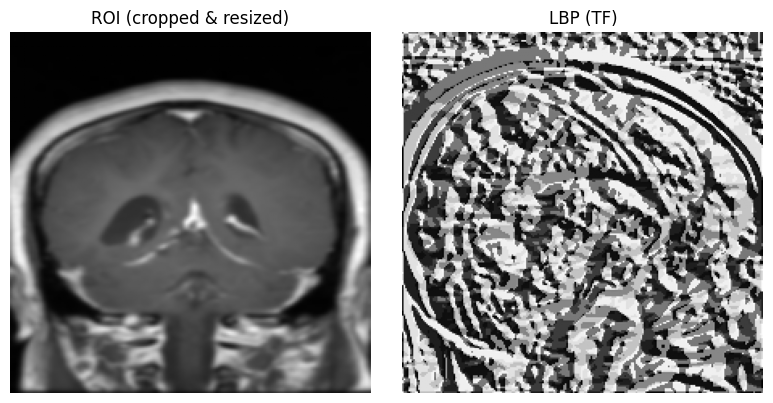

In [29]:
visualize_roi_vs_lbp(train_ds_roi, train_ds_roi_lbp)

In [30]:
def ensure_float01(images, labels):
    images = tf.cast(images, tf.float32)
    images = tf.clip_by_value(images, 0.0, 1.0)
    return images, labels

train_ds_final = train_ds_roi_lbp.map(ensure_float01)
validation_ds_final = validation_ds_roi_lbp.map(ensure_float01)
test_ds_final = test_ds_roi_lbp.map(ensure_float01)


In [31]:
def stack_gray_lbp(gray_batch, lbp_batch, labels):
    gray_batch = tf.cast(gray_batch, tf.float32)
    lbp_batch  = tf.cast(lbp_batch, tf.float32)

    gray_batch = tf.cond(tf.reduce_max(gray_batch) > 1.5, lambda: gray_batch/255.0, lambda: gray_batch)
    lbp_batch  = tf.cond(tf.reduce_max(lbp_batch)  > 1.5, lambda: lbp_batch/255.0,  lambda: lbp_batch)

    x = tf.concat([gray_batch, lbp_batch], axis=-1)  # (B,H,W,2)
    return x, labels



In [32]:
train_ds_2ch = tf.data.Dataset.zip((train_ds_roi, train_ds_roi_lbp)).map(
    lambda a, b: stack_gray_lbp(a[0], b[0], a[1])
)

val_ds_2ch = tf.data.Dataset.zip((validation_ds_roi, validation_ds_roi_lbp)).map(
    lambda a, b: stack_gray_lbp(a[0], b[0], a[1])
)

test_ds_2ch = tf.data.Dataset.zip((test_ds_roi, test_ds_roi_lbp)).map(
    lambda a, b: stack_gray_lbp(a[0], b[0], a[1])
)



In [33]:
train_ds_2ch = train_ds_2ch.shuffle(5000, seed=123, reshuffle_each_iteration=True)


In [34]:
class NovelAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.gap = tf.keras.layers.GlobalAveragePooling2D()
        self.dense = tf.keras.layers.Dense(None)
        self.relu = tf.keras.layers.Activation("relu")
        self.softmax = tf.keras.layers.Activation("softmax")
        self.reshape = tf.keras.layers.Reshape((1, 1, -1))
        self.mul = tf.keras.layers.Multiply()

    def build(self, input_shape):
        C = int(input_shape[-1])
        self.dense = tf.keras.layers.Dense(C)
        super().build(input_shape)

    def call(self, x):
        w = self.gap(x)
        w = self.dense(w)
        w = self.relu(w)
        w = self.softmax(w)
        w = self.reshape(w)
        return self.mul([x, w])

num_classes = int(train_ds_final.element_spec[1].shape[-1])

In [35]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([

    tf.keras.layers.Input(shape=(224,224,2)),

    tf.keras.layers.Conv2D(32, (3,3), padding="same"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.MaxPooling2D((2,2)),
    NovelAttention(),

    tf.keras.layers.Conv2D(32, (3,3), padding="same"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.25),
    NovelAttention(),

    tf.keras.layers.Conv2D(64, (3,3), padding="same"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(64, (3,3), padding="same"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.25),
    NovelAttention(),

    tf.keras.layers.Conv2D(64, (3,3), padding="same"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(64, (3,3), padding="same"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.25),
    NovelAttention(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [36]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [37]:
history = model.fit(
    train_ds_2ch,
    validation_data=val_ds_2ch,
    epochs=30,
)


Epoch 1/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 582s 1s/step - accuracy: 0.2626 - loss: 1.3860 - val_accuracy: 0.2892 - val_loss: 1.3844
Epoch 2/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 574s 1s/step - accuracy: 0.2742 - loss: 1.3849 - val_accuracy: 0.2892 - val_loss: 1.3830
Epoch 3/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 566s 1s/step - accuracy: 0.2656 - loss: 1.3852 - val_accuracy: 0.2892 - val_loss: 1.3827
Epoch 4/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 565s 1s/step - accuracy: 0.2819 - loss: 1.3833 - val_accuracy: 0.2892 - val_loss: 1.3823
Epoch 5/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 628s 1s/step - accuracy: 0.2736 - loss: 1.3840 - val_accuracy: 0.2892 - val_loss: 1.3822
Epoch 6/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 566s 1s/step - accuracy: 0.2782 - loss: 1.3835 - val_accuracy: 0.2892 - val_loss: 1.3813
Epoch 7/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 580s 1s/step - accuracy: 0.2803 - loss: 1.3837 - val_accuracy: 0.2892 - val_loss: 1.3817
Epoch 8/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 617s 1s/step - accuracy: 0.2735 - loss: 1.3839 - val_accu

In [38]:
test_loss, test_acc = model.evaluate(test_ds_2ch)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)


82/82 ━━━━━━━━━━━━━━━━━━━━ 78s 915ms/step - accuracy: 0.7218 - loss: 0.6686
Test accuracy: 0.7757437229156494
Test loss: 0.5380538702011108
